# Clustering Similar Questions

For the second part of this task I wanted to find major topics in the given data and cluster them accordingly.
The intuition behind this was that I wanted to segregate the text corpus into categories. Whenever a new customer query came, it could be clustered into pre-existing topics.

The software could then be used to suggest webpages or links to webpages which could be useful for solving queries relating to that particular cluster.

In [1]:
import pickle
import gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vibhormalik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
## Importing required libraries
import csv
import numpy as np 
import pandas as pd
import re
from zipfile import ZipFile 
from nltk.stem import WordNetLemmatizer
from nltk import TweetTokenizer, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from string import punctuation
punctuation = punctuation.replace("'", "")
import string
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import CoherenceModel
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA

### Getting data from tsv file

df = pd.DataFrame(columns = ['QuestionID', 'Question', 'DocumentID', 'DocumentTitle', 'SentenceID', 'Sentence', 'Label'])

with open('challenge.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    
    for row in reader:
        df = df.append({'QuestionID': row[0], 'Question': row[1], 'DocumentID': row[2] , 'DocumentTitle': row[3], 'SentenceID': row[4], 'Sentence': row[5], 'Label': row[6]}, ignore_index = True)

# df_['Question_processed'] = df_['Question_processed'].apply(lambda x: remove_stopwords(x))
# df_['Sentence_processed'] = df_['Sentence_processed'].apply(lambda x: remove_stopwords(x))

In [3]:
df = df[1:]

In [4]:
# Remove punctuation
df['Question_processed'] = df['Question'].map(lambda x: re.sub('[,\.!?]', '', x))
df['Sentence_processed'] = df['Sentence'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df['Sentence_processed'] = df['Sentence_processed'].map(lambda x: x.lower())
df['Question_processed'] = df['Question_processed'].map(lambda x: x.lower())

df_ = df[['Question_processed', 'Sentence_processed']]

In [5]:
### Removing Stop Words

stop_words = set(stopwords.words('english'))   

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [6]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [8]:
def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    
    words = list(sent_to_words(df['Question'].unique()))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [9]:
train_corpus, train_id2word, bigram_train = get_corpus(df)

### Get Optimal number of Topics

In [10]:
## COULDN'T RUN THE CODE IN A LOOP DUE TO EXTREMELY HIGH COMPUTATION TIME 

In [11]:
coherences = []

In [50]:
topics = 15

In [51]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=train_corpus,
                                       id2word=train_id2word,
                                       num_topics=topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_train, dictionary=train_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
coherences.append((topics, coherence_lda))


Coherence Score:  0.712786671219453


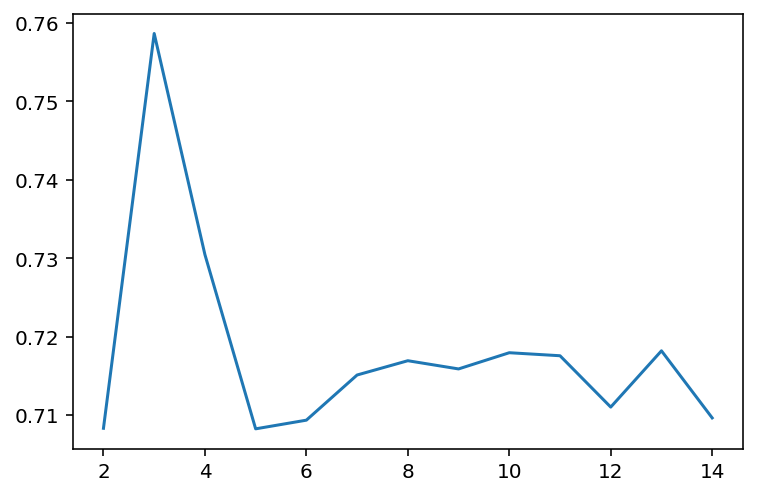

In [53]:
plt.plot([x[0] for x in coherences][:13], [x[1] for x in coherences][:13])

The coherence value seems to stabalize around 10 topics, staying around 0.71.

In [ ]:
## USING 10 AS OPTIMAL # OF TOPICS

In [55]:
lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=10,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=3, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)

### Make Vectors
Now that we have an LDA model, we need to run all the reviews through it using 'get document topics'. A list comprehension on that output (2nd line in loop) will give the probability distribution of the topics for a specific review, and that's our feature vector. The other 2 lines in the loop are hand-engineered features.

In [57]:
train_vecs = []
for i in range(len(df['Question'].unique())):
    top_topics = lda_train.get_document_topics(train_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    train_vecs.append(topic_vec)

In [58]:
topics = lda_train.print_topics(100,num_words=10)

In [59]:
best_topics = []
for i in train_vecs:
    maxpos = i.index(max(i))
    best_topics.append(maxpos)

In [60]:
temp_ = []
for i in best_topics:
    for j in topics:
        if j[0] == i:
            temp_.append(j[1])

In [61]:
final_df = pd.DataFrame()
final_df["Question"] = df["Question"].unique()
final_df["Topic"] = temp_

In [62]:
final_df.groupby(['Topic']).count()

,Question
Topic,
"0.150*""live"" + 0.130*""called"" + 0.124*""kind"" + 0.119*""house"" + 0.118*""book"" + 0.112*""invented"" + 0.097*""city"" + 0.096*""episode"" + 0.001*""system"" + 0.001*""people""",78
"0.193*""states"" + 0.166*""john"" + 0.153*""born"" + 0.125*""wrote"" + 0.113*""united"" + 0.107*""america"" + 0.094*""bible"" + 0.001*""population"" + 0.001*""life"" + 0.001*""president""",76
"0.195*""mean"" + 0.137*""old"" + 0.137*""get"" + 0.125*""president"" + 0.119*""die"" + 0.088*""system"" + 0.081*""life"" + 0.076*""big"" + 0.001*""invented"" + 0.001*""like""",1192
"0.213*""us"" + 0.129*""come"" + 0.121*""movie"" + 0.109*""day"" + 0.103*""american"" + 0.101*""created"" + 0.097*""married"" + 0.078*""like"" + 0.001*""largest"" + 0.001*""war""",86
"0.264*""state"" + 0.178*""time"" + 0.110*""long"" + 0.108*""type"" + 0.098*""use"" + 0.094*""plays"" + 0.088*""part"" + 0.001*""go"" + 0.001*""movie"" + 0.001*""make""",93
"0.295*""name"" + 0.278*""first"" + 0.141*""new"" + 0.092*""last"" + 0.092*""county"" + 0.067*""game"" + 0.001*""make"" + 0.001*""episode"" + 0.001*""played"" + 0.001*""year""",111
"0.307*""year"" + 0.261*""song"" + 0.176*""played"" + 0.100*""work"" + 0.098*""company"" + 0.001*""population"" + 0.001*""wrote"" + 0.001*""last"" + 0.001*""make"" + 0.001*""movie""",86
"0.317*""world"" + 0.150*""located"" + 0.137*""start"" + 0.115*""country"" + 0.091*""largest"" + 0.088*""good"" + 0.050*""make"" + 0.001*""population"" + 0.001*""war"" + 0.001*""countries""",76
"0.364*""made"" + 0.170*""much"" + 0.168*""war"" + 0.068*""go"" + 0.061*""civil"" + 0.061*""human"" + 0.049*""causes"" + 0.021*""make"" + 0.001*""population"" + 0.001*""start""",125


The model still seems to not be dicephering all the different topics in the corpus, grouping a lot of questions(about half), in the same category. I experimented with a higher number of topics however the results were not much better. The model continued to put about half the sentences in the same topic and segregated the rest into smaller and smaller groups.

Moreover, upon exploring the topics it came up with, I found that they did not make a lot of intuitive sense.

### To resolve this, I next tried modelling the text using a KMeans clustering model to see if it worked any better.

In [88]:
## Creating my own stop words remover
def remove_stopwords_1(example_sent):
    word_tokens = word_tokenize(example_sent) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    string = ''
    for word in filtered_sentence:
        string+=word+' '
    return string

In [91]:
df_ = df[['Question_processed', 'Sentence_processed']]
df_['Question_processed'] = df_['Question_processed'].apply(lambda x: remove_stopwords_1(x))
df_['Sentence_processed'] = df_['Sentence_processed'].apply(lambda x: remove_stopwords_1(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [93]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=20000,
                                 min_df=.005, stop_words='english',
                                 use_idf=True, ngram_range=(1,6))

tfidf_matrix = tfidf_vectorizer.fit_transform(df_['Question_processed'].unique())
# print(tfidf_matrix.shape)


Using the tf-idf matrix, I can run a slew of clustering algorithms to better understand the hidden structure within the data. 

K-means initializes with a pre-determined number of clusters. Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. 

Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

In [66]:
# K-means Clustering

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [67]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (201) found smaller than n_clusters (211). Possibly due to duplicate points in X.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (201) found smaller than n_clusters (241). Possibly due to duplicate points in X.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (201) found smaller than n_clusters (271). Possibly due to duplicate points in X.
  


Text(0.5, 1.0, 'Elbow Curve')

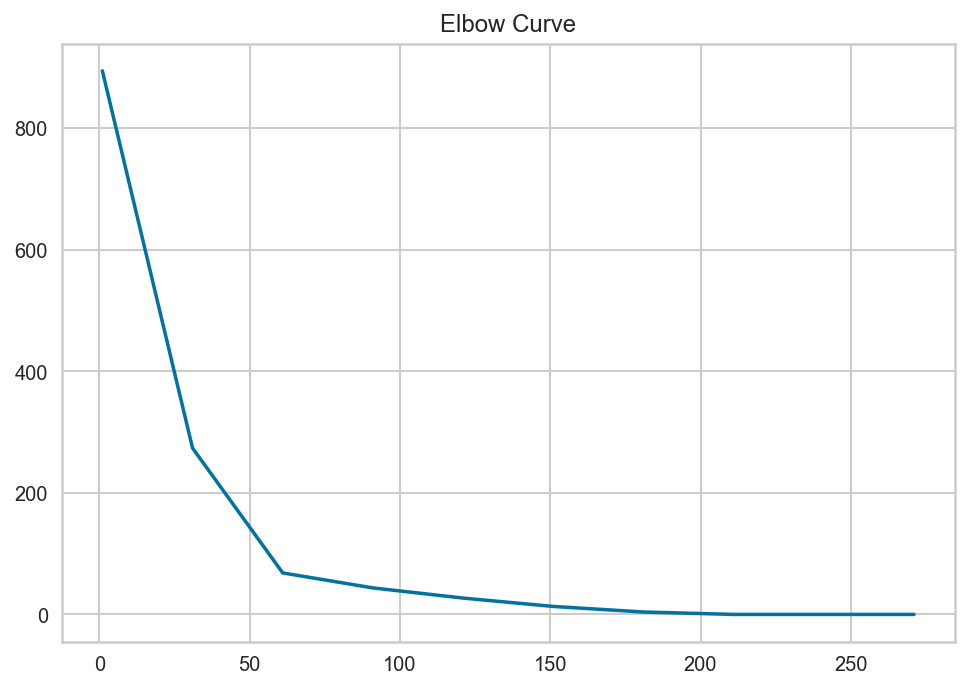

In [71]:
#### Now, lets try getting a elbow curve using inertia values trying different number of clusters. The aim was to find the optimal number of clusters to use.

lstx = []
lsty = []
for i in range(1, 300, 30):
    km = KMeans(n_clusters=i, max_iter=15, random_state=0).fit(tfidf_matrix.toarray())
    lstx.append(i)
    lsty.append(km.inertia_)
plt.plot(lstx, lsty)
plt.title('Elbow Curve')

### There's a clear elbow around 60 topics!

In [107]:
## Using 60 as the optimal number of clusters

num_clusters = 60
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

cluster_df_60 = pd.DataFrame()
cluster_df_60["Label"] = clusters
cluster_df_60["Question"] = df_['Question_processed'].unique()

cluster_df_60.groupby(['Label']).count()

,Question
Label,
0,1395
1,25
2,16
3,18
4,15
5,33
6,20
7,20
8,17


In [109]:
cluster_df_60[cluster_df_60["Label"] == 57]

,Label,Question
116,57,county texas conroe located
614,57,county augustaga located


In [110]:
cluster_df_60[cluster_df_60["Label"] == 54]

,Label,Question
1005,54,wrote song mood
1194,54,wrote song cocaine
1300,54,wrote song feelin alright
1374,54,wrote song little country >


In [114]:
## The smaller clusters as shown aboive have surprisingly similar sentences and show very promising results.

In [112]:
cluster_df_60[cluster_df_60["Label"] == 1]  # Algorithm seems to be grouping together sentences with "used"

,Label,Question
102,1,composer used sound mass
156,1,cords used wiccan
396,1,computer used
477,1,silk used
818,1,songs used sucker punch trailer
851,1,warehouse spreadsheets used
878,1,aluminum nitrate used
969,1,part corn used ethanol production
1009,1,religions used henna
1110,1,melon baller used


In [113]:
cluster_df_60[cluster_df_60["Label"] == 3] ## The topic here seems to be artists/songs

,Label,Question
546,3,artist song ashanti
732,3,originally song free zac brown band
737,3,song sung 6 foot 7 foot
752,3,establish song rocketeer
805,3,year beatles came song wan na hold hand
993,3,name song krs 1 dnice made
995,3,sings rap song uses spencer davis beat
1023,3,sung banana boat song
1347,3,made wwe cool song
1407,3,name main male character last song miley falls...


## As the smaller clusters seem to have sentences with far more contextual similarity, I tried using more clusters to see if the results would improve

In [117]:
## Using 150 as the optimal number of clusters

num_clusters = 150
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

cluster_df_150 = pd.DataFrame()
cluster_df_150["Label"] = clusters
cluster_df_150["Question"] = df_['Question_processed'].unique()

cluster_df_150.groupby(['Label']).count()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (142) found smaller than n_clusters (150). Possibly due to duplicate points in X.
  """


,Question
Label,
0,10
1,1395
2,19
3,25
4,14
...,...
137,1
138,1
139,1


It is evident that a similar problem exits when using the KMeans method for clustering the documents, where the model continued to put about half the sentences in the same topic and segregated the rest into smaller and smaller groups.¶When trying an increased number of clusters the model divides the existing categories into smaller and smaller groups, which takes away from its benefit of grouping together similar sentences.

It could be that the data simply has a lot of questions having nothing to do with each other, which is something that would flummox the model.

As the results from the elbow curve were inconclusive, I used the calsinki-harabasz metric in order to find an indicator of the right number of clusters to be used.


More details about the library can be found here: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html


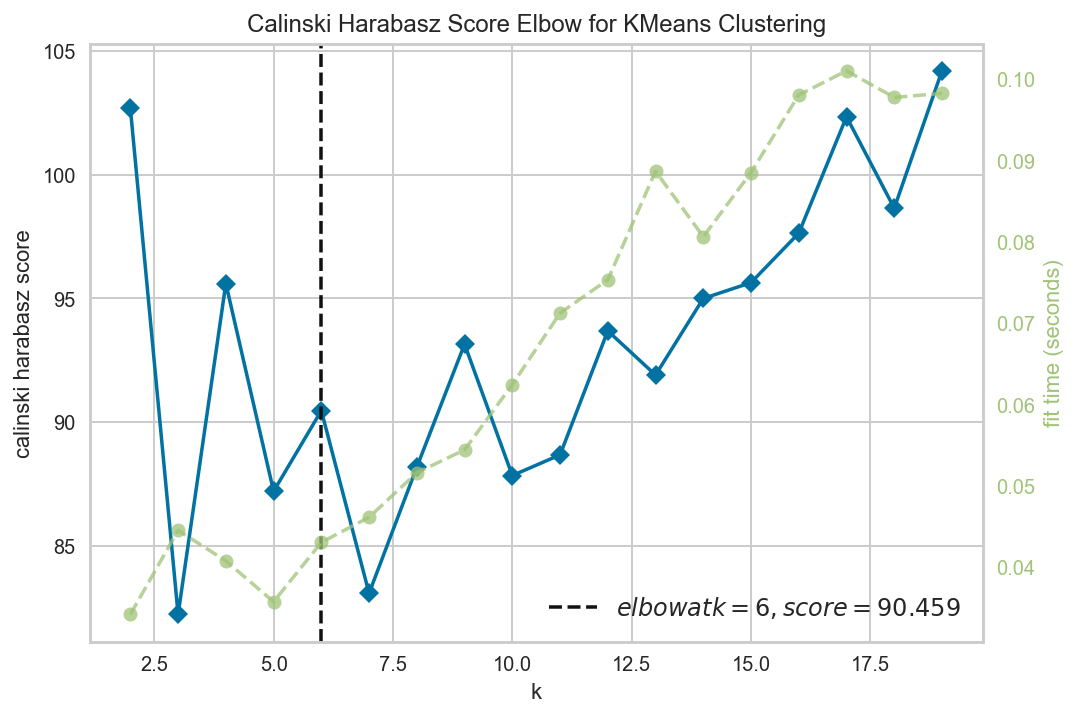

In [94]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20),  metric='calinski_harabasz')

visualizer.fit(tfidf_matrix.toarray())        # Fit the data to the visualizer
visualizer.show() 

In [99]:
## Using 6 as the optimal number of clusters

num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

cluster_df = pd.DataFrame()
cluster_df["Label"] = clusters
cluster_df["Question"] = df_['Question_processed'].unique()


cluster_df.Label.value_counts()

cluster_df.groupby(['Label']).count()

,Question
Label,
0,1976
1,37
2,30
3,28
4,21
5,23


In [100]:
# Exploring the clusters

In [102]:
cluster_df[cluster_df["Label"] == 1].head(7)

,Label,Question
119,1,wonderful world covers
131,1,many world series curt schilling
192,1,many websites world wide web
222,1,many teams world cup
259,1,many people world
261,1,many nuclear countries world
365,1,many gray wolves world


In [ ]:
## the algo seems to cluster on the word "world"

In [103]:
cluster_df[cluster_df["Label"] == 2].head(7)

,Label,Question
7,2,big girl scout cookie boxes used
102,2,composer used sound mass
156,2,cords used wiccan
396,2,computer used
477,2,silk used
495,2,constitutionalism used american government today
818,2,songs used sucker punch trailer


In [ ]:
## the algo seems to cluster on the word "used"

In [104]:
cluster_df[cluster_df["Label"] == 3].head(7)

,Label,Question
52,3,territory become state
112,3,mean commonwealth state
173,3,universal law gravitation state
277,3,division boise state football
361,3,solid state drive work
382,3,city oregon state university
471,3,many wide state virginia


In [ ]:
## the algo seems to cluster on the word "state"

It is apparent that the Kmeans algorithm is also not able to extract a lot of context from the data in its current form.

Given more time to play with the data I would try more unsupervised method to learn more about the data. I would also explore some deep learning methods to develop embeddings for the data and try to draw more contextual information about the text. However, given the short amount of data I'm not very optimistic about the effectiveness of a Neural Network